In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import time

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import (Dense, Conv2D, BatchNormalization, Activation, 
                          AveragePooling2D, Input, Flatten, 
                          Concatenate, Dropout, Lambda, 
                          Reshape, Embedding, Multiply)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model, Sequential, load_model
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from __future__ import print_function
%matplotlib inline

Using TensorFlow backend.


# Dataset

In [0]:
class Dataset_CIFAR10:
    def __init__(self, num_labeled):

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            return x

        def preprocess_labels(y):
            y = y.reshape(-1, 1)
            y = to_categorical(y, num_classes = 10)
            return y

        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = preprocess_imgs(x_train)
        y_train = preprocess_labels(y_train)
        x_test = preprocess_imgs(x_test)
        y_test = preprocess_labels(y_test)

        # Number labeled examples to use for training
        self.num_labeled = num_labeled
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        del x_train, y_train, x_test, y_test

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        return self.x_train, self.y_train

    def test_set(self):
        return self.x_test, self.y_test

## Check the data

In [4]:
# CIFAR-10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Training set
d_ytrain = {}
for i in range(10):
  d_ytrain[i] = 0
for i in range(len(y_train)):
  d_ytrain[y_train[i][0]] = d_ytrain.get(y_train[i][0]) + 1
print("CIFAR-10 training set:")
print(d_ytrain)

# Test set
d_ytest = {}
for i in range(10):
  d_ytest[i] = 0
for i in range(len(y_test)):
  d_ytest[y_test[i][0]] = d_ytest.get(y_test[i][0]) + 1
print("CIFAR-10 test set:")
print(d_ytest)

del x_train, y_train, x_test, y_test

CIFAR-10 training set:
{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
CIFAR-10 test set:
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


# Number of labeled data

In [0]:
num_labeled = 1000

# SCGAN-2D

## Build the model

In [0]:
# Training parameters
input_shape = img_shape = (32, 32, 3)
num_classes = 10
z_dim = 100   # Size of the noise vector, used as input to the Generator
n = 3
depth = n * 6 + 2   # Depth of ResNet model

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [0]:
# CIFAR-10

def build_generator(z_dim):
  
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ), dtype='float32')
    label_embedding = Dense(z_dim, input_dim=num_classes)(label)
    joined_representation = Multiply()([z, label_embedding])
    
#     model = Sequential()

    # Reshape input into 8x8x256 tensor via a fully connected layer
    model = Dense(256 * 8 * 8, input_dim=z_dim)(joined_representation)
    model = Reshape((8, 8, 256))(model)

    # Transposed convolution layer, from 8x8x256 into 16x16x128 tensor
    model = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 16x16x128 to 16x16x64 tensor
    model = Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 16x16x64 to 32x32x3 tensor
    model = Conv2DTranspose(3, kernel_size=3, strides=2, padding='same')(model)

    # Output layer with tanh activation
    conditioned_img = Activation('tanh')(model)
    
#     conditioned_img = model(joined_representation)

    model = Model([z, label], conditioned_img)

    return model

In [0]:
def build_discriminator_net(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, kernel_initializer='he_normal')(y)
    # outputs = Dense(num_classes,
    #                 activation='softmax',
    #                 kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [47]:
build_discriminator_net(img_shape, depth).summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 32, 32, 16)   448         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_121 (BatchN (None, 32, 32, 16)   64          conv2d_127[0][0]                 
__________________________________________________________________________________________________
activation_123 (Activation)     (None, 32, 32, 16)   0           batch_normalization_121[0][0]    
___________________________________________________________________________________________

In [0]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [0]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

In [0]:
def build_gan(generator, discriminator):
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ))
    img = generator([z, label])
    output = discriminator(img)
    model = Model([z, label], output)

    return model

In [0]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training

discriminator_net = build_discriminator_net(input_shape=img_shape, depth=depth)

discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())
# discriminator_supervised.compile(loss='categorical_crossentropy',
#                                  metrics=['accuracy'],
#                                  optimizer=Adam(lr=lr_schedule(0)))

discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                metrics=['accuracy'],
                                optimizer=Adam())
# discriminator_unsupervised.compile(loss='binary_crossentropy',
#                                 metrics=['accuracy'],
#                                 optimizer=Adam(lr=lr_schedule(0)))


In [53]:
discriminator_unsupervised.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 10)                274442    
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 274,442
Trainable params: 273,066
Non-trainable params: 1,376
_________________________________________________________________


In [15]:
# Build the Generator
generator = build_generator(z_dim)

discriminator_supervised.trainable = False
discriminator_unsupervised.trainable = False
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', 
            metrics=['accuracy'], 
            optimizer=Adam())

## Training

In [77]:
%mkdir models
%mkdir losses
%mkdir models/models-label-1000
%mkdir losses/losses-label-1000

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘losses’: File exists
mkdir: cannot create directory ‘losses/losses-label-1000’: File exists


In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'cifar10_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))

history = LossHistory()

callbacks = [checkpoint, lr_reducer, lr_scheduler, history]

In [0]:
# Data augmentation

datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

In [0]:
def pretrain(iterations_pre, batch_size, save_interval, iter_epochs):
  for iteration in range(iterations_pre):
      imgs, labels = dataset.training_set()
      # imgs, labels = dataset.batch_labeled(batch_size)
      x_test, y_test = dataset.test_set()

      # Compute quantities required for featurewise normalization (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(imgs)
      discriminator_supervised.fit_generator(datagen.flow(imgs, labels, batch_size=batch_size),
                  validation_data=(x_test, y_test),
                  epochs=iter_epochs, verbose=1, workers=4,
                  callbacks=callbacks)
      
      if (iteration + 1) % save_interval == 0:
          
          # Output training progress
          print(
              "%d [D loss class: %.4f, acc: %.2f%%]"
              % (iteration + 1, history.losses[-1], 100 * history.accs[-1]))
          iteration_checkpoints.append(iteration + 1)
          losses.append(history.losses[-1])
          accs.append(history.accs[-1])
          discriminator_supervised.save_weights("./models/discriminator_supervised-" + str(iteration+1) + ".h5")
          
          # x, y = dataset.training_set()
          # _, accuracy = discriminator_supervised.evaluate(x, y)
          # print("Training Accuracy: %.2f%%" % (100 * accuracy))      

In [0]:
# def pretrain(iterations_pre, batch_size, save_interval):
#   for iteration in range(iterations_pre):
#       # imgs, labels = dataset.training_set()
#       imgs, labels = dataset.batch_labeled(1000)
      
#       loss, acc = discriminator_supervised.train_on_batch(imgs, labels)
      
#       if (iteration + 1) % save_interval == 0:

#           losses.append(loss)
#           accs.append(acc)
#           iteration_checkpoints.append(iteration + 1)
          
#           # Output training progress
#           print(
#               "%d [D loss class: %.4f, acc: %.2f%%]"
#               % (iteration + 1, loss, 100 * acc))
#           discriminator_supervised.save("./models/discriminator_supervised-" + str(iteration+1) + ".h5")
          
#           # x, y = dataset.training_set()
#           # _, accuracy = discriminator_supervised.evaluate(x, y)
#           # print("Training Accuracy: %.2f%%" % (100 * accuracy))      

In [28]:
# Set hyperparameters
iterations_pre = 1
iter_epochs = 10    # 20
batch_size = 32
save_interval = 1
losses = []
accs = []
iteration_checkpoints = []

dataset = Dataset_CIFAR10(num_labeled)

discriminator_supervised.trainable = True

starttime = time.clock()

pretrain(iterations_pre, batch_size, save_interval
         , iter_epochs
         )

endtime = time.clock()
print("Use time:" + str(endtime-starttime) + "s")

Epoch 1/20
Learning rate:  0.001
1563/1563 [==============================] - 97s 62ms/step - loss: 1.5701 - acc: 0.4472 - val_loss: 1.3243 - val_acc: 0.5593

Epoch 00001: val_acc improved from -inf to 0.55930, saving model to /content/useless_models/cifar10_model.001.h5
Epoch 2/20
Learning rate:  0.001
1563/1563 [==============================] - 92s 59ms/step - loss: 1.1708 - acc: 0.6105 - val_loss: 1.0860 - val_acc: 0.6451

Epoch 00002: val_acc improved from 0.55930 to 0.64510, saving model to /content/useless_models/cifar10_model.002.h5
Epoch 3/20
Learning rate:  0.001
1563/1563 [==============================] - 93s 59ms/step - loss: 0.9983 - acc: 0.6797 - val_loss: 1.1369 - val_acc: 0.6633

Epoch 00003: val_acc improved from 0.64510 to 0.66330, saving model to /content/useless_models/cifar10_model.003.h5
Epoch 4/20
Learning rate:  0.001
1563/1563 [==============================] - 94s 60ms/step - loss: 0.9064 - acc: 0.7191 - val_loss: 1.0271 - val_acc: 0.6893

Epoch 00004: val_ac

In [31]:
x, y = dataset.training_set()

tmodel = build_discriminator_supervised(build_discriminator_net(img_shape, depth))
tmodel.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())
# tmodel.load_weights("./models/discriminator_supervised-2000.h5", by_name=False)
tmodel.load_weights("./models/cifar10_model.019.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

50000/50000 [==============================] - 19s 375us/step
Training Accuracy: 86.19%


In [43]:
x, y = dataset.test_set()

tmodel.load_weights("./models/cifar10_model.019.h5", by_name=False)

# Compute classification accuracy on the test set
_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 4s 365us/step
Test Accuracy: 83.45%


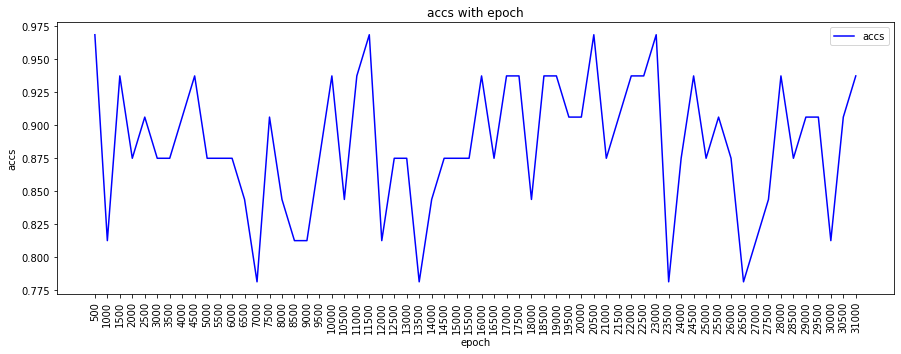

In [42]:
div = 500
ty = [history.accs[i*div] for i in range(0, len(history.accs)//div)]
tx = [x for x in range(1*div, (len(ty)+1)*div, div)]

plt.figure(figsize=(15, 5))
plt.plot(tx, ty, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
# accs = []
# tx = [x for x in range(100,2100,100)]
# acc_max = [0,0]

# x, y = dataset.test_set()

# tmodel = build_discriminator_supervised(build_discriminator_net(img_shape, depth))
# tmodel.compile(loss='categorical_crossentropy',
#                          metrics=['accuracy'],
#                          optimizer=Adam())

# for e in tx:
#   tmodel.load_weights("./models/discriminator_supervised-"+ str(e) +".h5", by_name=False)
#   _, acc = tmodel.evaluate(x, y)
#   accs.append(acc)
# print(max(accs))

# plt.figure(figsize=(15, 5))
# plt.plot(tx, accs, label="accs", color='blue')
# plt.xticks(tx, rotation=90)
# plt.title("accs with epoch")
# plt.xlabel("epoch")
# plt.ylabel("accs")
# plt.legend()

In [0]:
def train(iterations, batch_size, save_interval, iter_epochs, k):

    x_test, y_test = dataset.test_set()

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        for _ in range(k):

            # -------------------------
            #  Train the Discriminator
            # -------------------------

            # Get labeled and unlabeled examples
            imgs, labels = dataset.batch_labeled(batch_size)
            imgs_unlabeled = dataset.batch_unlabeled(batch_size)

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            fake_labels = to_categorical(fake_labels, num_classes=num_classes)
            gen_imgs = generator.predict([z, fake_labels])

            discriminator_supervised.trainable = True
            discriminator_unsupervised.trainable = True

            # Train on real labeled examples
            datagen.fit(imgs)
            discriminator_supervised.fit_generator(datagen.flow(imgs, labels, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=iter_epochs, verbose=1, workers=4,
                        callbacks=callbacks)
            loss_d_supervised, acc_d_supervised = history.losses[-1], history.accs[-1]

            # Train on real unlabeled examples
            # Error
            # datagen.fit(imgs_unlabeled)
            # discriminator_unsupervised.fit_generator(datagen.flow(imgs_unlabeled, real, batch_size=batch_size),
            #             validation_data=(x_test, np.ones((len(x_test), 1))),
            #             epochs=iter_epochs, verbose=1, workers=4,
            #             callbacks=callbacks)
            # loss_d_unsupervised_real, acc_d_unsupervised_real = history.losses[-1], history.accs[-1]
            loss_d_unsupervised_real, acc_d_unsupervised_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)

            # Train on fake examples
            loss_d_unsupervised_fake, acc_d_unsupervised_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

            # Calculate loss and acc
            loss_d_unsupervised = 0.5 * np.add(loss_d_unsupervised_real, loss_d_unsupervised_fake)
            loss_d = np.add(loss_d_supervised, loss_d_unsupervised)
            acc_d_unsupervised = 0.5 * np.add(acc_d_unsupervised_real, acc_d_unsupervised_fake)
            acc_d = np.add(acc_d_supervised, acc_d_unsupervised)
        
        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        fake_labels = to_categorical(fake_labels, num_classes=num_classes)
        gen_imgs = generator.predict([z, fake_labels])

        discriminator_supervised.trainable = False
        discriminator_unsupervised.trainable = False

        # Train Generator
        loss_g_unsupervised, acc_g_unsupervised = gan.train_on_batch([z,labels], real)

        # Calculate loss and acc
        loss_g = loss_g_unsupervised
        acc_g = acc_g_unsupervised

        if (iteration + 1) % save_interval == 0:

            # Save losses to be plotted after training
            losses_d_supervised.append(loss_d_supervised)
            losses_d_unsupervised.append(loss_d_unsupervised)
            losses_d_unsupervised_real.append(loss_d_unsupervised_real)
            losses_d_unsupervised_fake.append(loss_d_unsupervised_fake)
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]"
                % (iteration + 1, 
                   loss_d_supervised, 100 * acc_d_supervised,
                   loss_d_unsupervised, 100 * acc_d_unsupervised, 
                   loss_g, 100 * acc_g))
            
            discriminator_supervised.save("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-" + str(iteration+1) + ".h5")
            discriminator_unsupervised.save("./models/models-label-" + str(num_labeled) + "/discriminator_unsupervised-" + str(iteration+1) + ".h5")
            generator.save("./models/models-label-" + str(num_labeled) + "/generator-" + str(iteration+1) + ".h5")
            file1 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_supervised.json"
            file2 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_unsupervised.json"
            file3 = "./losses/losses-label-" + str(num_labeled) + "/losses_g.json"
            with open(file1, 'w') as json_file:
                  json.dump(str(losses_d_supervised), json_file)
            with open(file2, 'w') as json_file:
                  json.dump(str(losses_d_unsupervised), json_file)
            with open(file3, 'w') as json_file:
                  json.dump(str(losses_g), json_file)

            # x,y = dataset.training_set()
            # _, acc = discriminator_supervised.evaluate(x,y)
            # print(str(100*acc)+"%")

In [78]:
# Set hyperparameters
iterations = 300 # 8000
iter_epochs = 1 # 10
batch_size = 32
save_interval = 10
k = 1 # iteration of Discriminator

losses_d_supervised = []
losses_d_unsupervised = []
losses_d_unsupervised_real = []
losses_d_unsupervised_fake = []
losses_d = []
losses_g = []

iteration_checkpoints = []

# discriminator_supervised = load_model("./models/discriminator_supervised-1200.h5")
discriminator_supervised = load_model("./useless_models/cifar10_model.019.h5")
starttime = time.clock()

# Train the SCGAN-2D for the specified number of iterations
train(iterations, batch_size, save_interval, iter_epochs, k)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

Epoch 1/1
Learning rate:  0.001
1/1 [==============================] - 26s 26s/step - loss: 0.5122 - acc: 0.8438 - val_loss: 0.6732 - val_acc: 0.8324

Epoch 00001: val_acc did not improve from 0.83500
1 [D loss supervised: 0.5122, acc.: 84.38%] [D loss unsupervised: 0.2705, acc.: 100.00%] [G loss: 2.962576, acc.: 0.00%]
Epoch 1/1
Learning rate:  0.001
1/1 [==============================] - 5s 5s/step - loss: 0.4464 - acc: 0.8750 - val_loss: 0.6423 - val_acc: 0.8387

Epoch 00001: val_acc improved from 0.83500 to 0.83870, saving model to /content/models/cifar10_model.001.h5
2 [D loss supervised: 0.4464, acc.: 87.50%] [D loss unsupervised: 0.2706, acc.: 98.44%] [G loss: 3.046097, acc.: 0.00%]
Epoch 1/1
Learning rate:  0.001
1/1 [==============================] - 5s 5s/step - loss: 0.5002 - acc: 0.8750 - val_loss: 0.6390 - val_acc: 0.8393

Epoch 00001: val_acc improved from 0.83870 to 0.83930, saving model to /content/models/cifar10_model.001.h5
3 [D loss supervised: 0.5002, acc.: 87.50%] 

## Evaluate

In [79]:
x, y = dataset.training_set()

tmodel = build_discriminator_supervised(build_discriminator_net(img_shape, depth))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-300.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

50000/50000 [==============================] - 33s 665us/step
Training Accuracy: 86.13%


In [80]:
x, y = dataset.test_set()

tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-300.h5", by_name=False)

# Compute classification accuracy on the test set
_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 5s 516us/step
Test Accuracy: 83.33%


10000/10000 [==============================] - 5s 501us/step
0.8479


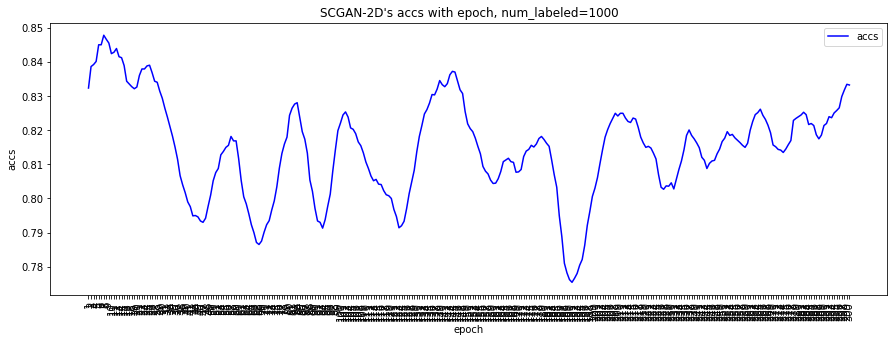

In [81]:
div = 10
accs = []
tx = [x for x in range(1*div, (len(iteration_checkpoints)+1) * div, div)]
acc_max = [0,0]

for e in tx:
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("SCGAN-2D's accs with epoch, num_labeled=%d" % num_labeled)
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

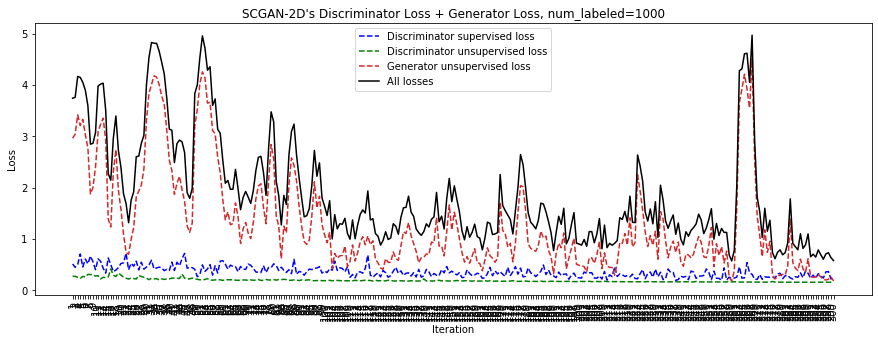

In [82]:
d_supervised_loss = np.array(losses_d_supervised)
d_unsupervised_loss = np.array(losses_d_unsupervised)
d_unsupervised_real_loss = np.array(losses_d_unsupervised_real)
d_unsupervised_fake_loss = np.array(losses_d_unsupervised_fake)
d_loss = np.array(losses_d)
g_loss = np.array(losses_g)  # Generator unsupervised loss
all_loss = np.add(d_loss, g_loss)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, d_supervised_loss, label="Discriminator supervised loss", color='blue', linestyle='dashed')
plt.plot(iteration_checkpoints, d_unsupervised_loss, label="Discriminator unsupervised loss", color='green', linestyle='dashed')
# plt.plot(iteration_checkpoints, d_unsupervised_real_loss, label="Discriminator unsupervised real loss", color='yellow')
# plt.plot(iteration_checkpoints, d_unsupervised_fake_loss, label="Discriminator unsupervised fake loss", color='yellow')
plt.plot(iteration_checkpoints, g_loss, label="Generator unsupervised loss", color='tab:red', linestyle='dashed')
plt.plot(iteration_checkpoints, all_loss, label="All losses", color='black')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("SCGAN-2D's Discriminator Loss + Generator Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## Generate Pictures

In [0]:
# z = np.random.normal(0, 1, (batch_size, z_dim))
# fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
# fake_labels = to_categorical(fake_labels, num_classes=num_classes)
# gen_imgs = generator.predict([z, fake_labels])

def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    fake_labels = [0,1,2,3,4,5,6,7,8,9]
    fake_labels_category = to_categorical(fake_labels, num_classes=num_classes)

    # Generate images from random noise
    gen_imgs = generator.predict([z, fake_labels_category])

    # Rescale image pixel values to [0, 1]
    # gen_imgs = 0.5 * gen_imgs + 0.5
    # gen_imgs = (gen_imgs+1) * 255/2

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            axs[i, j].set_title("Class: " + str(d_name[fake_labels[cnt]]))
            cnt += 1

In [0]:
sample_images()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


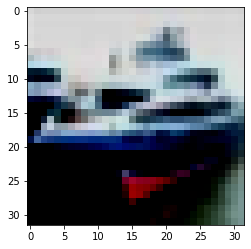

In [94]:
d_name = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}		
i = 1				
plt.imshow(x_test[i],cmap='binary')
print(y_test[i])

In [0]:
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12,14)
    if num>25: num=25
    for i in range(0,num):
        ax = plt.subplot(5,5,i+1)
        ax.imshow(images[idx],cmap='binary') 
        title= str(i)+' '+label_dict[labels[i][0]]   #显示数字对应的类别
        if len(prediction)>0:
            title+= '=>'+label_dict[prediction[i]]   #显示数字对应的类别
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.show()

plot_images_labels_prediction(x_train,y_train,[],0)

# Pseudo Label

In [0]:
pseudo_model = build_discriminator_supervised(build_discriminator_net(img_shape, depth))
pseudo_model.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [0]:
def pseudo_train(iterations, batch_size, save_interval, alpha_f, t1, t2):

    for iteration in range(iterations):

        # Get unlabeled examples and pseudo labels
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
        pseudo_label = pseudo_model.predict(imgs_unlabeled)

        # -------------------------
        #  Supervised Training
        # -------------------------

        # Get labeled examples
        imgs_labeled, labels = dataset.batch_labeled(batch_size)

        # Train on labeled examples
        alpha = 1
        loss_labeled, acc_labeled = pseudo_model.train_on_batch(imgs_labeled, labels)

        loss_unlabeled = -1
        acc_unlabeled = -1

        # -------------------------
        #  Supervised Training
        # -------------------------

        # Set alpha
        if iteration < t1: alpha = 0
        else:
            if t1 <= iteration < t2: alpha = (iteration - t1)/(t2 - t1) * alpha_f
            else: alpha = alpha_f

            # Train on unlabeled examples
            loss_unlabeled, acc_unlabeled = pseudo_model.train_on_batch(imgs_unlabeled, pseudo_label)

        if (iteration + 1) % save_interval == 0:

          # Save losses
          losses_pseudo_labeled.append(loss_labeled)
          losses_pseudo_unlabeled.append(loss_unlabeled)
          losses_pseudo.append(loss_labeled + alpha * loss_unlabeled)
          accs_pseudo_labeled.append(acc_labeled)
          accs_pseudo_unlabeled.append(acc_unlabeled)
          accs_pseudo.append((acc_labeled + alpha*acc_unlabeled)/(1 + alpha))
          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print(
              "%d [supervised loss: %.4f, acc: %.2f%%] [unsupervised loss: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_labeled, 100 * acc_labeled, 
                  loss_unlabeled, 100 * acc_unlabeled))
          
          pseudo_model.save("./models/models-label-" + str(num_labeled) + "/pseudo-" + str(iteration+1) + ".h5")
          file1 = "./losses/losses-label-" + str(num_labeled) + "/p_supervised_losses.json"
          file2 = "./losses/losses-label-" + str(num_labeled) + "/p_unsupervised_losses.json"
          file3 = "./losses/losses-label-" + str(num_labeled) + "/p_losses.json"
          with open(file1, 'w') as json_file:
                json.dump(str(losses_pseudo_labeled), json_file)
          with open(file2, 'w') as json_file:
                json.dump(str(losses_pseudo_unlabeled), json_file)
          with open(file3, 'w') as json_file:
                json.dump(str(losses_pseudo), json_file)

In [86]:
# Set hyperparameters
iterations = 8000 # 8000
batch_size = 32
save_interval = 100
alpha_f = 3
t1 = 500 #200
t2 = 1000 # 600

losses_pseudo_labeled = []
losses_pseudo_unlabeled = []
losses_pseudo = []
accs_pseudo_labeled = []
accs_pseudo_unlabeled = []
accs_pseudo = []
iteration_checkpoints = []

discriminator_supervised.trainable = True
pseudo_model = load_model("./useless_models/cifar10_model.019.h5")

starttime = time.clock()

# Train the SGGAN for the specified number of iterations
pseudo_train(iterations, batch_size, save_interval, alpha_f, t1, t2)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [supervised loss: 1.1440, acc: 62.50%] [unsupervised loss: -1.0000, acc: -100.00%]
200 [supervised loss: 0.6264, acc: 90.62%] [unsupervised loss: -1.0000, acc: -100.00%]
300 [supervised loss: 0.4965, acc: 93.75%] [unsupervised loss: -1.0000, acc: -100.00%]
400 [supervised loss: 0.2295, acc: 100.00%] [unsupervised loss: -1.0000, acc: -100.00%]
500 [supervised loss: 0.1895, acc: 100.00%] [unsupervised loss: -1.0000, acc: -100.00%]
600 [supervised loss: 0.7249, acc: 87.50%] [unsupervised loss: 1.9265, acc: 46.88%]
700 [supervised loss: 1.4268, acc: 43.75%] [unsupervised loss: 0.7180, acc: 90.62%]
800 [supervised loss: 0.5148, acc: 90.62%] [unsupervised loss: 1.0420, acc: 84.38%]
900 [supervised loss: 0.7068, acc: 84.38%] [unsupervised loss: 1.8924, acc: 56.25%]
1000 [supervised loss: 0.5015, acc: 90.62%] [unsupervised loss: 1.1968, acc: 90.62%]
1100 [supervised loss: 0.9784, acc: 56.25%] [unsupervised loss: 0.6339, acc: 100.00%]
1200 [supervised loss: 0.3472, acc: 96.88%] [unsupervise

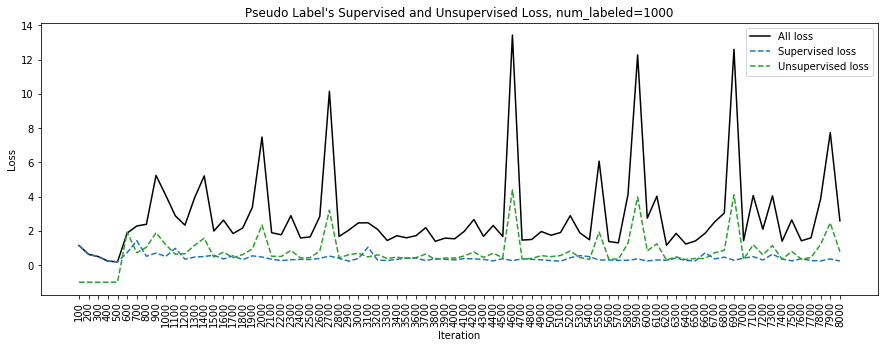

In [100]:
plot_pseudo_supervised_losses = np.array(losses_pseudo_labeled)
plot_pseudo_unsupervised_losses = np.array(losses_pseudo_unlabeled)
plot_pseudo_all_losses = np.array(losses_pseudo)

# Plot losses
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, plot_pseudo_all_losses, label="All loss", color='black')
plt.plot(iteration_checkpoints, plot_pseudo_supervised_losses, label="Supervised loss", color='tab:blue', linestyle='dashed')
plt.plot(iteration_checkpoints, plot_pseudo_unsupervised_losses, label="Unsupervised loss", color='tab:green', linestyle='dashed')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Pseudo Label's Supervised and Unsupervised Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [104]:
x, y = dataset.training_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-8000.h5")
tmodel = build_discriminator_supervised(build_discriminator_net(img_shape, depth))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

50000/50000 [==============================] - 34s 677us/step
Training Accuracy: 13.95%


In [105]:
x, y = dataset.test_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-6000.h5")
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-5900.h5", by_name=False)

_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 5s 510us/step
Test Accuracy: 10.00%


10000/10000 [==============================] - 5s 525us/step
0.327


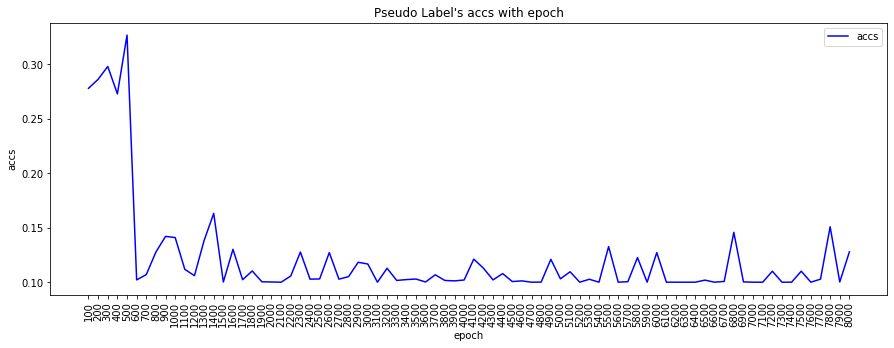

In [103]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  # tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-"+ str(e) +".h5")
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("Pseudo Label's accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
for acc in accs:
  print(acc)

# Mean Teacher

In [0]:
student = build_discriminator_supervised(build_discriminator_net(img_shape, depth))
teacher = build_discriminator_supervised(build_discriminator_net(img_shape, depth))
student.compile(loss='categorical_crossentropy', 
                metrics=['accuracy'], 
                optimizer=Adam())
teacher.compile(loss='categorical_crossentropy', 
                metrics=['accuracy'], 
                optimizer=Adam())

In [0]:
def mean_teacher_train(iterations, batch_size, save_interval, alpha):

    for iteration in range(iterations):

        # -------------------------
        #  Train the model
        # -------------------------

        # Get labeled examples
        imgs_labeled, labels = dataset.batch_labeled(batch_size)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Train on labeled examples
        loss_labeled_classification, acc_labeled_classification = student.train_on_batch(imgs_labeled, labels)
        pred_teacher_labeled = teacher.predict(imgs_labeled)
        loss_labeled_consistency, acc_labeled_consistency = student.train_on_batch(imgs_labeled, pred_teacher_labeled)

        # Train on unlabeled examples
        pred_teacher_unlabeled = teacher.predict(imgs_unlabeled)
        loss_unlabeled_consistency, acc_unlabeled_consistency = student.train_on_batch(imgs_unlabeled, pred_teacher_unlabeled)

        # Update teacher model
        teacher_weights_this = teacher.get_weights()
        student_weights_this = student.get_weights()
        for i in range(len(teacher_weights_this)):
          teacher_weights_this[i] = alpha * teacher_weights_this[i] + (1-alpha) * student_weights_this[i]
        # teacher_weights_this = alpha * teacher_weights_this + (1-alpha) * student_weights_this
        teacher_weights_last = teacher_weights_this
        teacher.set_weights(teacher_weights_this)

        if (iteration + 1) % save_interval == 0:

          # Save losses
          supervised_losses.append(loss_labeled_classification)
          unsupervised_losses.append(loss_labeled_consistency + loss_unlabeled_consistency)
          labeled_consistency_costs.append(loss_labeled_consistency)
          unlabeled_consistency_costs.append(loss_unlabeled_consistency)
          accs_supervised.append(acc_labeled_classification)
          accs_unsupervised.append((acc_labeled_consistency + acc_unlabeled_consistency)/2.0)
          accs_labeled_consistency.append(acc_labeled_consistency)
          accs_unlabeled_consistency.append(acc_unlabeled_consistency)

          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print(
              "%d [supervised loss: %.4f, acc: %.2f%%] [unsupervised loss: %.4f, acc: %.2f%%] [labeled consistency loss: %.4f, acc:acc: %.2f%%] [unlabeled consistency loss: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_labeled_classification, 100 * acc_labeled_classification, 
                 loss_labeled_consistency + loss_unlabeled_consistency, 100 * ((acc_labeled_consistency + acc_unlabeled_consistency)/2.0), 
                 loss_labeled_consistency, 100 * acc_labeled_consistency, 
                  loss_unlabeled_consistency, 100 * acc_unlabeled_consistency))
          
          student.save("./models/models-label-" + str(num_labeled) + "/student-" + str(iteration+1) + ".h5")
          teacher.save("./models/models-label-" + str(num_labeled) + "/teacher-" + str(iteration+1) + ".h5")
          file1 = "./losses/losses-label-" + str(num_labeled) + "/mt_supervised_losses.json"
          file2 = "./losses/losses-label-" + str(num_labeled) + "/mt_unsupervised_losses.json"
          file3 = "./losses/losses-label-" + str(num_labeled) + "/mt_labeled_consistency_costs.json"
          file4 = "./losses/losses-label-" + str(num_labeled) + "/mt_unlabeled_consistency_costs.json"
          with open(file1, 'w') as json_file:
                json.dump(str(supervised_losses), json_file)
          with open(file2, 'w') as json_file:
                json.dump(str(unsupervised_losses), json_file)
          with open(file3, 'w') as json_file:
                json.dump(str(labeled_consistency_costs), json_file)
          with open(file4, 'w') as json_file:
                json.dump(str(unlabeled_consistency_costs), json_file)

In [109]:
# Set hyperparameters
iterations = 8000 # 8000
batch_size = 32
save_interval = 100
alpha = 0.5

supervised_losses = [] # classification cost
unsupervised_losses = [] # consistency cost
labeled_consistency_costs = []
unlabeled_consistency_costs = []
accs_supervised = []
accs_unsupervised = []
accs_labeled_consistency = []
accs_unlabeled_consistency = []
iteration_checkpoints = []

discriminator_supervised.trainable = True
student = load_model("./useless_models/cifar10_model.019.h5")

starttime = time.clock()

# Train the mean teacher for the specified number of iterations
mean_teacher_train(iterations, batch_size, save_interval, alpha)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [supervised loss: 2.2336, acc: 28.12%] [unsupervised loss: 3.7505, acc: 70.31%] [labeled consistency loss: 1.8543, acc:acc: 71.88%] [unlabeled consistency loss: 1.8962, acc: 68.75%]
200 [supervised loss: 2.1307, acc: 28.12%] [unsupervised loss: 3.6973, acc: 60.94%] [labeled consistency loss: 1.8145, acc:acc: 65.62%] [unlabeled consistency loss: 1.8828, acc: 56.25%]
300 [supervised loss: 2.0295, acc: 15.62%] [unsupervised loss: 4.1281, acc: 45.31%] [labeled consistency loss: 2.0125, acc:acc: 43.75%] [unlabeled consistency loss: 2.1156, acc: 46.88%]
400 [supervised loss: 1.2338, acc: 62.50%] [unsupervised loss: 3.0651, acc: 65.62%] [labeled consistency loss: 1.5094, acc:acc: 62.50%] [unlabeled consistency loss: 1.5556, acc: 68.75%]
500 [supervised loss: 1.9076, acc: 31.25%] [unsupervised loss: 3.7669, acc: 45.31%] [labeled consistency loss: 1.9895, acc:acc: 37.50%] [unlabeled consistency loss: 1.7773, acc: 53.12%]
600 [supervised loss: 1.2489, acc: 50.00%] [unsupervised loss: 2.4845,

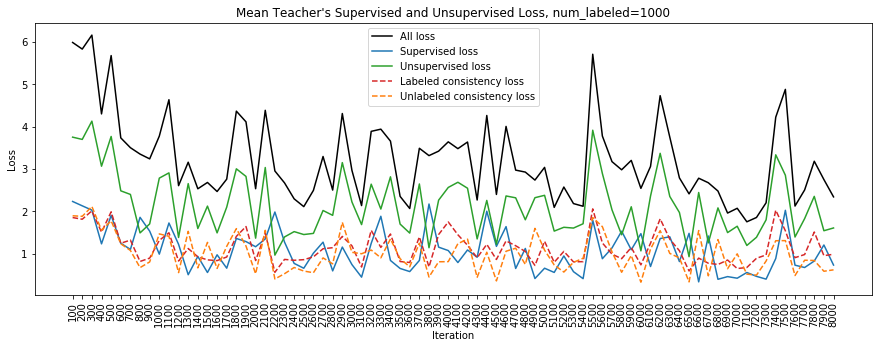

In [110]:
plot_supervised_losses = np.array(supervised_losses)
plot_unsupervised_losses = np.array(unsupervised_losses)
plot_labeled_consistency_costs = np.array(labeled_consistency_costs)
plot_unlabeled_consistency_costs = np.array(unlabeled_consistency_costs)
plot_all_losses = np.array(supervised_losses)+np.array(unsupervised_losses)

# Plot losses
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, plot_all_losses, label="All loss", color='black')
plt.plot(iteration_checkpoints, plot_supervised_losses, label="Supervised loss", color='tab:blue')
plt.plot(iteration_checkpoints, plot_unsupervised_losses, label="Unsupervised loss", color='tab:green')
plt.plot(iteration_checkpoints, plot_labeled_consistency_costs, label="Labeled consistency loss", color='tab:red', linestyle='dashed')
plt.plot(iteration_checkpoints, plot_unlabeled_consistency_costs, label="Unlabeled consistency loss", color='tab:orange', linestyle='dashed')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Mean Teacher's Supervised and Unsupervised Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [0]:
x, y = dataset.training_set()

tmodel = build_discriminator_supervised(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

In [0]:
x, y = dataset.test_set()

tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-6100.h5", by_name=False)

# Compute classification accuracy on the test set
_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

In [0]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("Mean Teacher's accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
for acc in accs:
  print(acc)

# To be deleted

In [0]:
model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

model.summary()

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'useless_models')
model_name = 'cifar10_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))

history = LossHistory()

callbacks = [checkpoint, lr_reducer, lr_scheduler, history]

In [0]:
# Data augmentation

datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

In [0]:
def train(iterations, batch_size, iter_epochs, save_interval):

    x_test, y_test = dataset.test_set()

    for iteration in range(iterations):

        imgs, labels = dataset.batch_labeled(batch_size)

        # Compute quantities required for featurewise normalization (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(imgs)
        model.fit_generator(datagen.flow(imgs, labels, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=iter_epochs, verbose=1, workers=4,
                    callbacks=callbacks)
        
        if (iteration + 1) % save_interval == 0:
            losses.append(history.losses[-1])
            accs.append(history.accs[-1])
            iteration_checkpoints.append(iteration + 1)
            discriminator_supervised.save("./models/model-" + str(iteration+1) + ".h5")

In [0]:
iterations = 5
iter_epochs = 10
save_interval = 10
batch_size = 32
num_labeled = 100
losses = []
accs = []
iteration_checkpoints = []

dataset = Dataset_CIFAR10(num_labeled)

starttime = time.clock()

train(iterations, batch_size, iter_epochs, save_interval)

endtime = time.clock()
print("Use time:" + str(endtime-starttime) + "s")

Epoch 1/10
Learning rate:  0.001
1/1 [==============================] - 3s 3s/step - loss: 0.2716 - acc: 1.0000 - val_loss: 1.5633 - val_acc: 0.7275

Epoch 00001: val_acc did not improve from 0.73420
Epoch 2/10
Learning rate:  0.001
1/1 [==============================] - 3s 3s/step - loss: 0.2799 - acc: 1.0000 - val_loss: 1.5599 - val_acc: 0.7273

Epoch 00002: val_acc did not improve from 0.73420
Epoch 3/10
Learning rate:  0.001
1/1 [==============================] - 3s 3s/step - loss: 0.2757 - acc: 1.0000 - val_loss: 1.5565 - val_acc: 0.7272

Epoch 00003: val_acc did not improve from 0.73420
Epoch 4/10
Learning rate:  0.001
1/1 [==============================] - 3s 3s/step - loss: 0.2784 - acc: 1.0000 - val_loss: 1.5532 - val_acc: 0.7272

Epoch 00004: val_acc did not improve from 0.73420
Epoch 5/10
Learning rate:  0.001
1/1 [==============================] - 3s 3s/step - loss: 0.2789 - acc: 1.0000 - val_loss: 1.5482 - val_acc: 0.7278

Epoch 00005: val_acc did not improve from 0.73420


In [0]:
# Score trained model.
x_test, y_test = dataset.test_set()
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 315us/step
Test loss: 1.5306017761230468
Test accuracy: 0.7148


In [0]:
print(losses)
print(accs)

[]
[]


In [0]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)